# LRFinder: Learning Rate Finder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import time
import os
import numpy as np

In [2]:
import matplotlib.pyplot as plt

We set the random seed so all of our experiments can be reproduced.

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently. 

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [4]:
ROOT = '../data'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation. 

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [5]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(7),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=3), #, padding_mode='reflect'),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

val_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [7]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

val_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = val_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')

Number of training examples: 50000
Number of validation examples: 10000


Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to `permute` our images before plotting them.

Ignore the `normalize` argument for now, we'll explain it shortly.

In [10]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

When we plot them we see lots of warnings. This is because `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

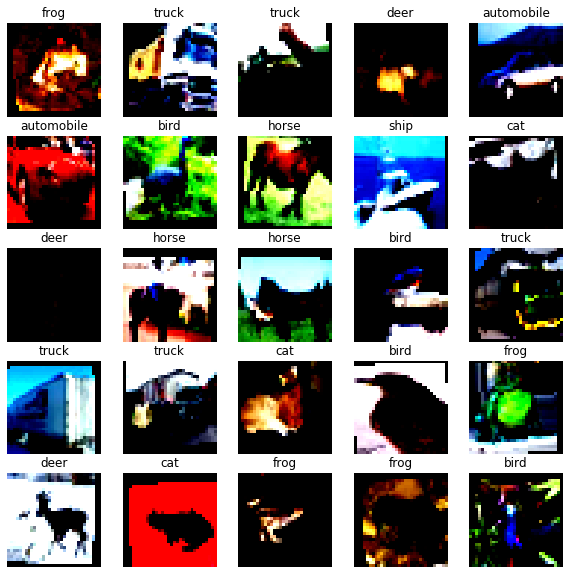

In [12]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = train_data.classes

plot_images(images, labels, classes)

A solution to this is to *renormalize* the images so each pixel is between $[0,1]$. This is done by clipping the pixel values between the maximum and minimum within an image and then scaling each pixel between $[0,1]$ using these maximum and minimums. 

As we can see the images below look a lot more like we were expecting, along with the rotations and cropping.

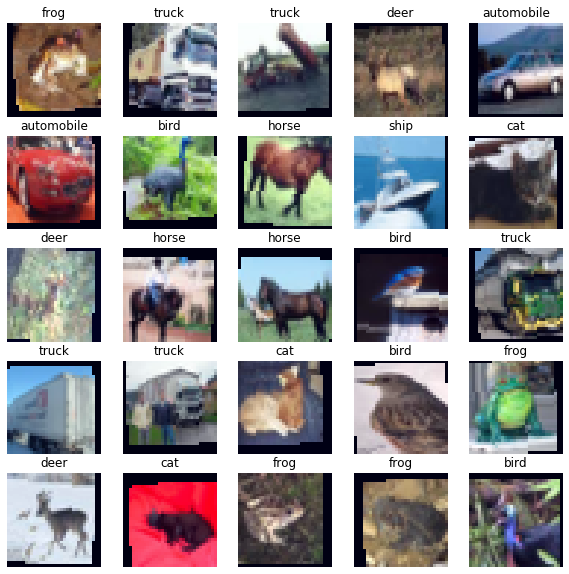

In [13]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [14]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [16]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(val_data, 
                                 batch_size = BATCH_SIZE)

# test_iterator = data.DataLoader(test_data, 
#                                 batch_size = BATCH_SIZE)

In [17]:
class myNet(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()
        kernel_size = 5
        out_ch = 100
        n_targets = output_dim
        
        self.features =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2, 32->16

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 16 -> 8

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 8 -> 4

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),

                      nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),

                      nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1];
                      nn.Flatten() # [B, 2]
                     )

    def forward(self, x):
        x = self.features(x)
        return x
#

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,034,010 trainable parameters


---
## LRFinder

Next up is the learning rate finder. The code here is taken from a stripped down version of the excellent [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 

**Note**: the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us 100% accuracy - but it is usually going to be better than just picking a learning rate out of thin air.  

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we our defined maximum learning rate. 

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated. 

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.

In [19]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        self.ls = []
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        self.ls = []
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            self.ls.append(loss)
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch # + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [20]:
START_LR = 1e-7

optimizer = optim.SGD(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = myNet(10)
model = model.to(device)
criterion = criterion.to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test` with the training iterator, the maximum learning rate and the number of iterations we want to use. 

In [21]:
%%time
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Wall time: 13 s


Next, we can plot the learning rate against the loss. 

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [22]:
def plot_lr_finder(lrs, losses, skip_start=0, skip_end=0, title='', style='-'):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses, style)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
#    ax.grid(True)
    ax.grid(True, 'both', 'x')
    ax.set_title(title)
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before flattening out and spiking up. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$. 

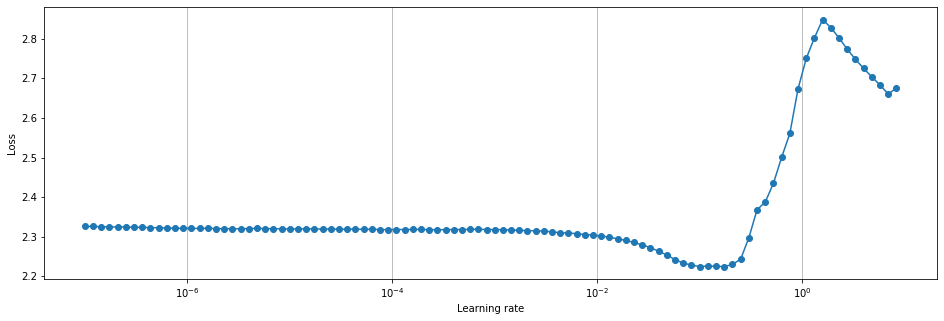

In [23]:
plot_lr_finder(lrs, losses, style='-o')

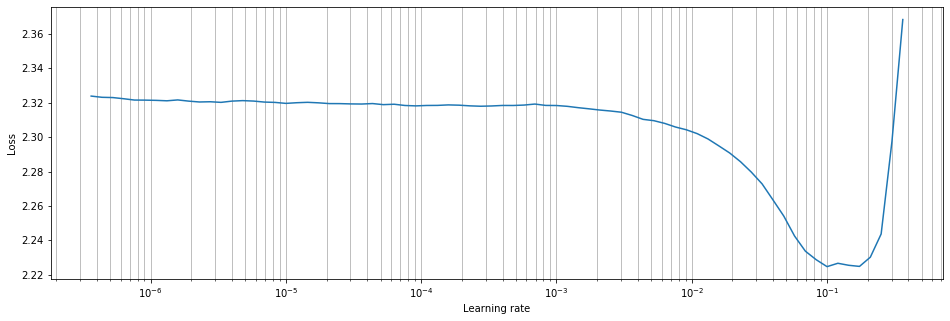

In [24]:
plot_lr_finder(lrs, losses, skip_start=7, skip_end=17)

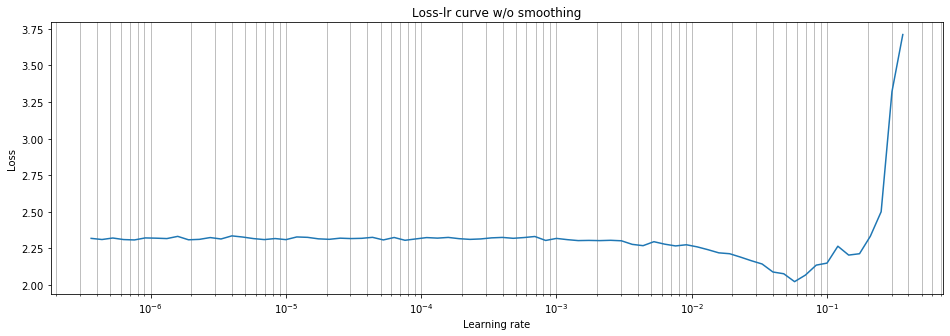

In [25]:
plot_lr_finder(lrs, lr_finder.ls, skip_start=7, skip_end=17, title='Loss-lr curve w/o smoothing')

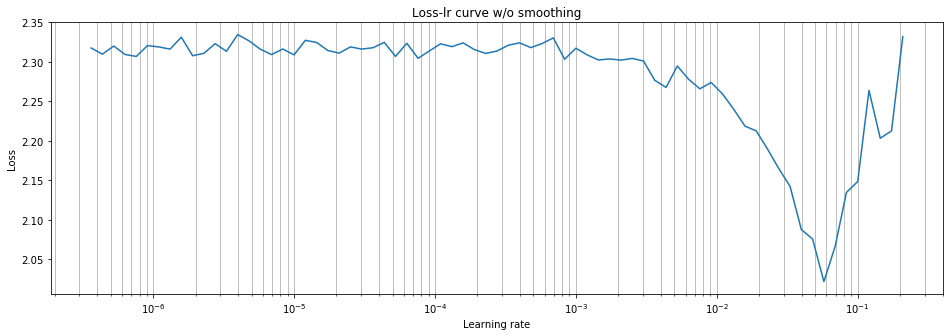

In [26]:
plot_lr_finder(lrs, lr_finder.ls, skip_start=7, skip_end=20, title='Loss-lr curve w/o smoothing')

In [30]:
FOUND_LR = 1e-1 / 2.

optimizer = optim.SGD(model.parameters(), lr = FOUND_LR)
lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=(1e-2 + 1e-3)/2., max_lr=1e-1, step_size_up=len(train_iterator))

In [31]:
import training_loop as tx
import importlib
importlib.reload(tx)

<module 'training_loop' from 'D:\\git\\iadl\\class\\training_loop.py'>

In [32]:
history = tx.training_loop(10, optimizer, model, criterion, train_iterator, valid_iterator, lr_scheduler=lrscheduler, hist=None, device=device, verbose=True)

Epoch 1, tloss 1.07 vloss 1.11  t_acc: 0.62 v_acc: 0.61  ellapsed: 24.74sec 
Epoch 2, tloss 0.91 vloss 0.92  t_acc: 0.68 v_acc: 0.67  ellapsed: 24.85sec 
Epoch 3, tloss 0.82 vloss 0.80  t_acc: 0.71 v_acc: 0.72  ellapsed: 24.92sec 
Epoch 4, tloss 0.74 vloss 0.78  t_acc: 0.74 v_acc: 0.72  ellapsed: 25.24sec 
Epoch 5, tloss 0.69 vloss 0.71  t_acc: 0.76 v_acc: 0.75  ellapsed: 25.37sec 
Epoch 6, tloss 0.63 vloss 0.69  t_acc: 0.78 v_acc: 0.76  ellapsed: 25.53sec 
Epoch 7, tloss 0.60 vloss 0.74  t_acc: 0.79 v_acc: 0.75  ellapsed: 25.52sec 
Epoch 8, tloss 0.57 vloss 0.70  t_acc: 0.80 v_acc: 0.76  ellapsed: 24.96sec 
Epoch 9, tloss 0.55 vloss 0.61  t_acc: 0.81 v_acc: 0.79  ellapsed: 25.14sec 
Epoch 10, tloss 0.52 vloss 0.70  t_acc: 0.82 v_acc: 0.77  ellapsed: 24.90sec 
best model is loaded. finished training_loop(). 


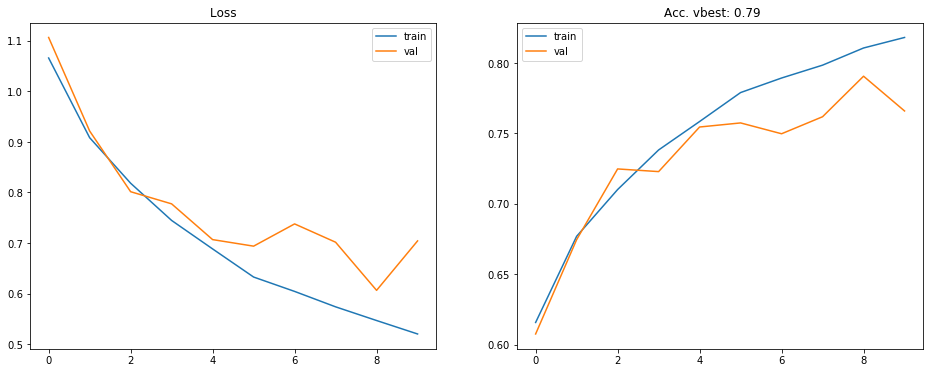

In [33]:
tx.plot_history(history)

Epoch 1, tloss 0.53 vloss 0.66  t_acc: 0.82 v_acc: 0.78  ellapsed: 24.93sec 
Epoch 2, tloss 0.50 vloss 0.67  t_acc: 0.83 v_acc: 0.78  ellapsed: 24.79sec 
Epoch 3, tloss 0.47 vloss 0.73  t_acc: 0.83 v_acc: 0.76  ellapsed: 24.79sec 
Epoch 4, tloss 0.46 vloss 0.62  t_acc: 0.84 v_acc: 0.80  ellapsed: 25.00sec 
Epoch 5, tloss 0.43 vloss 0.56  t_acc: 0.85 v_acc: 0.81  ellapsed: 24.72sec 
Epoch 6, tloss 0.42 vloss 0.59  t_acc: 0.85 v_acc: 0.80  ellapsed: 25.20sec 
Epoch 7, tloss 0.41 vloss 0.51  t_acc: 0.86 v_acc: 0.83  ellapsed: 24.92sec 
Epoch 8, tloss 0.39 vloss 0.61  t_acc: 0.86 v_acc: 0.80  ellapsed: 25.03sec 
Epoch 9, tloss 0.37 vloss 0.54  t_acc: 0.87 v_acc: 0.82  ellapsed: 24.96sec 
Epoch 10, tloss 0.36 vloss 0.50  t_acc: 0.87 v_acc: 0.84  ellapsed: 24.79sec 
best model is loaded. finished training_loop().  / (tacc: 0.87436) --


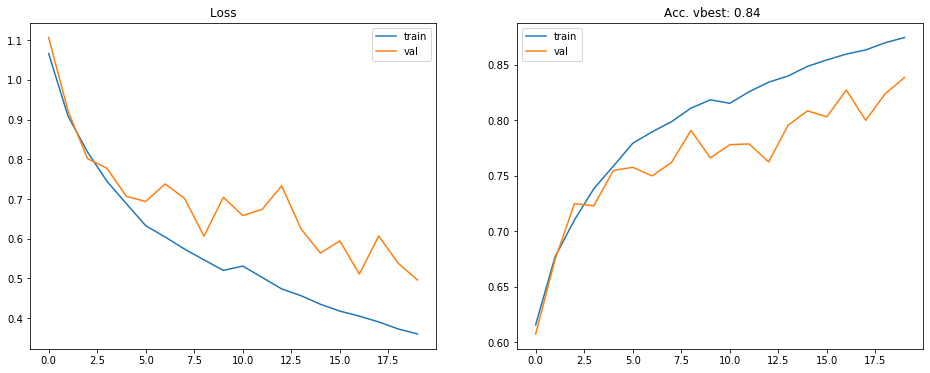

In [34]:
history = tx.training_loop(10, optimizer, model, criterion, train_iterator, valid_iterator, 
                           hist=history, 
                           device=device, verbose=True)
tx.plot_history(history)

Epoch 1, tloss 0.35 vloss 0.52  t_acc: 0.88 v_acc: 0.83  ellapsed: 24.69sec 
Epoch 2, tloss 0.34 vloss 0.50  t_acc: 0.88 v_acc: 0.84  ellapsed: 24.84sec 
Epoch 3, tloss 0.33 vloss 0.50  t_acc: 0.88 v_acc: 0.84  ellapsed: 24.64sec 
Epoch 4, tloss 0.32 vloss 0.48  t_acc: 0.89 v_acc: 0.85  ellapsed: 24.71sec 
Epoch 5, tloss 0.31 vloss 0.48  t_acc: 0.89 v_acc: 0.85  ellapsed: 24.78sec 
Epoch 6, tloss 0.30 vloss 0.49  t_acc: 0.89 v_acc: 0.85  ellapsed: 24.97sec 
Epoch 7, tloss 0.29 vloss 0.42  t_acc: 0.90 v_acc: 0.86  ellapsed: 24.92sec 
Epoch 8, tloss 0.28 vloss 0.53  t_acc: 0.90 v_acc: 0.85  ellapsed: 24.77sec 
Epoch 9, tloss 0.28 vloss 0.48  t_acc: 0.90 v_acc: 0.85  ellapsed: 24.70sec 
Epoch 10, tloss 0.27 vloss 0.49  t_acc: 0.90 v_acc: 0.85  ellapsed: 24.95sec 
Epoch 11, tloss 0.26 vloss 0.53  t_acc: 0.91 v_acc: 0.84  ellapsed: 24.90sec 
Epoch 12, tloss 0.25 vloss 0.45  t_acc: 0.91 v_acc: 0.86  ellapsed: 24.79sec 
Epoch 13, tloss 0.25 vloss 0.45  t_acc: 0.91 v_acc: 0.86  ellapsed: 24.73

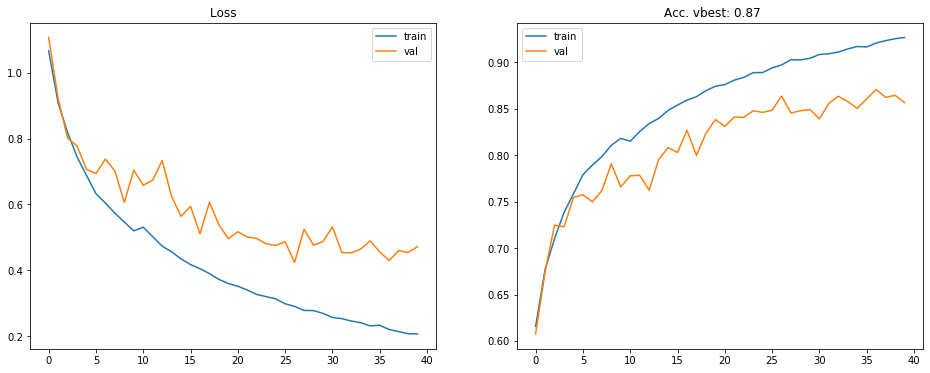

In [36]:
history = tx.training_loop(20, optimizer, model, criterion, train_iterator, valid_iterator, 
                           hist=history, 
                           device=device, verbose=True)
tx.plot_history(history)

---

## Summary
- My Model produced 87% accuracy and have more room to go up.
- Conv2d + Batchnorm + ReLU combination is good
- LRFinder
- CyclicLR worked epoch-wise. It should have been a step-wise update.
    - see the next jupyter notebook for this.
    - `training_loop.py` is modified to allow step-wise update of the lrscheduler.

End.